In [72]:
import pandas as pd
import numpy as np
from pathlib import Path
from ts.utils.data_utils import download_yahoo_finance_ticker
import plotly.express as px
from ts.utils.plot_utils import decorate_plot, decomposition_plot, plot_autocorrelation
from statsmodels.tsa.seasonal import seasonal_decompose
from ts.utils.data_utils import add_freq
from ts.decomposition.seasonal import STL, FourierDecomposition, MultiSeasonalDecomposition
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from ts.utils.ts_utils import make_stationary
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
sp500_companies = pd.read_csv("data/SP500/sp500_companies.csv")
sp500_companies.head()

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,248.13,3750683475968,1.346610e+11,0.061,Cupertino,CA,United States,164000.0,"Apple Inc. designs, manufactures, and markets ...",0.066030
1,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,447.27,3325398614016,1.365520e+11,0.160,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.058543
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,134.25,3287782522880,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.057881
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,227.46,2391742087168,1.115830e+11,0.110,Seattle,WA,United States,1551000.0,"Amazon.com, Inc. engages in the retail sale of...",0.042106
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,189.82,2332223602688,1.234700e+11,0.151,Mountain View,CA,United States,181269.0,Alphabet Inc. offers various products and plat...,0.041058


In [3]:
sp500_companies.iloc[sp500_companies["Weight"].idxmax()]

Exchange                                                             NMS
Symbol                                                              AAPL
Shortname                                                     Apple Inc.
Longname                                                      Apple Inc.
Sector                                                        Technology
Industry                                            Consumer Electronics
Currentprice                                                      248.13
Marketcap                                                  3750683475968
Ebitda                                                    134660997120.0
Revenuegrowth                                                      0.061
City                                                           Cupertino
State                                                                 CA
Country                                                    United States
Fulltimeemployees                                  

In [4]:
symbols_ls = sp500_companies["Symbol"].to_list()
symbols_ls

['AAPL',
 'MSFT',
 'NVDA',
 'AMZN',
 'GOOGL',
 'GOOG',
 'META',
 'TSLA',
 'AVGO',
 'BRK-B',
 'WMT',
 'LLY',
 'JPM',
 'V',
 'XOM',
 'MA',
 'ORCL',
 'UNH',
 'COST',
 'HD',
 'PG',
 'NFLX',
 'JNJ',
 'BAC',
 'CRM',
 'ABBV',
 'CVX',
 'KO',
 'TMUS',
 'MRK',
 'PANW',
 'WFC',
 'CSCO',
 'NOW',
 'BX',
 'ACN',
 'PEP',
 'IBM',
 'AXP',
 'MCD',
 'LIN',
 'AMD',
 'DIS',
 'MS',
 'ADBE',
 'TMO',
 'PM',
 'ABT',
 'ISRG',
 'GS',
 'INTU',
 'CAT',
 'GE',
 'VZ',
 'QCOM',
 'TXN',
 'PLTR',
 'BKNG',
 'DHR',
 'T',
 'BLK',
 'SPGI',
 'RTX',
 'CMCSA',
 'NEE',
 'LOW',
 'HON',
 'PGR',
 'SCHW',
 'AMGN',
 'PFE',
 'SYK',
 'UNP',
 'KKR',
 'ANET',
 'ETN',
 'TJX',
 'AMAT',
 'C',
 'BSX',
 'COP',
 'BA',
 'UBER',
 'ADP',
 'DE',
 'VRTX',
 'LMT',
 'FI',
 'NKE',
 'GILD',
 'MU',
 'BMY',
 'CB',
 'SBUX',
 'UPS',
 'ADI',
 'MDT',
 'MMC',
 'PLD',
 'LRCX',
 'EQIX',
 'MO',
 'AMT',
 'SHW',
 'GEV',
 'PYPL',
 'SO',
 'CRWD',
 'TT',
 'ICE',
 'APH',
 'MCO',
 'ELV',
 'CMG',
 'INTC',
 'KLAC',
 'PH',
 'WM',
 'CME',
 'CTAS',
 'CDNS',
 'DUK',
 'DELL

In [5]:
len(symbols_ls)

503

In [6]:
SYMBOL = "NVDA"
file_path = Path(f"data/SP500/{SYMBOL}.csv")
if file_path.exists():
    print(f'{file_path} exist alors on le charge')
    data = pd.read_csv(file_path)
else:
    data = download_yahoo_finance_ticker(SYMBOL, start="2020-01-01", end="2024-06-30", save_file=file_path)
    print(f'{SYMBOL} data is download and save to {file_path} path')

data\SP500\NVDA.csv exist alors on le charge


In [7]:
data.head()

,Ticker,NVDA,NVDA.1,NVDA.2,NVDA.3,NVDA.4,NVDA.5
0,Price,Open,High,Low,Close,Adj Close,Volume
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,5.96875,5.9977498054504395,5.918000221252441,5.9977498054504395,5.972710132598877,237536000
3,2020-01-03,5.877500057220459,5.9457502365112305,5.852499961853027,5.901750087738037,5.87711238861084,205384000
4,2020-01-06,5.808000087738037,5.9317498207092285,5.781750202178955,5.926499843597412,5.90175724029541,262636000


In [9]:
df = data.iloc[2:]
df.columns = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
df.set_index("Date")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2,2020-01-02,5.96875,5.9977498054504395,5.918000221252441,5.9977498054504395,5.972710132598877,237536000
3,2020-01-03,5.877500057220459,5.9457502365112305,5.852499961853027,5.901750087738037,5.87711238861084,205384000
4,2020-01-06,5.808000087738037,5.9317498207092285,5.781750202178955,5.926499843597412,5.90175724029541,262636000
5,2020-01-07,5.954999923706055,6.044250011444092,5.909749984741211,5.9982500076293945,5.973209381103516,314856000
6,2020-01-08,5.99399995803833,6.051000118255615,5.953750133514404,6.009500026702881,5.984410762786865,277108000


In [10]:
df  = df.set_index("Date")
df.index = pd.to_datetime(df.index)
print(type(df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [11]:
df.loc["2020":"2022"]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,5.96875,5.9977498054504395,5.918000221252441,5.9977498054504395,5.972710132598877,237536000
2020-01-03,5.877500057220459,5.9457502365112305,5.852499961853027,5.901750087738037,5.87711238861084,205384000
2020-01-06,5.808000087738037,5.9317498207092285,5.781750202178955,5.926499843597412,5.90175724029541,262636000
2020-01-07,5.954999923706055,6.044250011444092,5.909749984741211,5.9982500076293945,5.973209381103516,314856000
2020-01-08,5.99399995803833,6.051000118255615,5.953750133514404,6.009500026702881,5.984410762786865,277108000
...,...,...,...,...,...,...
2022-12-23,15.196000099182129,15.33899974822998,14.883000373840332,15.206000328063965,15.19494915008545,349326000
2022-12-27,15.074000358581543,15.100000381469727,14.055999755859375,14.121000289916992,14.110735893249512,464902000
2022-12-28,13.927000045776367,14.26200008392334,13.883999824523926,14.03600025177002,14.025798797607422,351066000


In [12]:
df = df.astype('float')
df = df.round(3)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,5.969,5.998,5.918,5.998,5.973,237536000.0
2020-01-03,5.878,5.946,5.852,5.902,5.877,205384000.0
2020-01-06,5.808,5.932,5.782,5.926,5.902,262636000.0
2020-01-07,5.955,6.044,5.910,5.998,5.973,314856000.0
2020-01-08,5.994,6.051,5.954,6.010,5.984,277108000.0


In [13]:

ts_df = df[["Close"]]
ts_df.head()

,Close
Date,
2020-01-02,5.998
2020-01-03,5.902
2020-01-06,5.926
2020-01-07,5.998
2020-01-08,6.010


In [14]:
fig = px.line(df.loc["2023":"2024"], y="Close", title="NVIDIA STOCK PRICE")
fig = decorate_plot(fig, ylabel="Price")
fig.show()

In [15]:
ts_df = ts_df.resample("1B").asfreq()

In [16]:
ts_df.isna().sum()

Close    42
dtype: int64

In [17]:
ts_df = ts_df.ffill()

In [18]:
ts_df.isna().sum()

Close    0
dtype: int64

In [36]:
decomp_result = seasonal_decompose(ts_df["Close"], filt=np.repeat(1/30, 30))

In [35]:
decomposition_plot(ts_index=ts_df.index, 
                   observed=decomp_result.observed, 
                   seasonal=decomp_result.seasonal, 
                   trend=decomp_result.trend, 
                   resid=decomp_result.resid)

In [42]:
stl = STL(ts_df["Close"])
decomp_result_slt = stl.fit()

In [43]:
decomposition_plot(ts_index=ts_df.index, 
                   observed=decomp_result_slt.observed, 
                   seasonal=decomp_result_slt.seasonal, 
                   trend=decomp_result_slt.trend, 
                   resid=decomp_result_slt.resid)

In [53]:
plot_autocorrelation(ts_df["Close"])

In [44]:
adf_res = adfuller(ts_df["Close"])
adf_res

(2.5018349992564914,
 0.9990504398513582,
 10,
 1161,
 {'1%': -3.43599497601695,
  '5%': -2.8640326585367473,
  '10%': -2.5680971485495068},
 3603.9994333879586)

In [45]:
ts_st , inverse_transform= make_stationary(ts_df["Close"].to_numpy(), method="logdiff")

In [46]:
adf_res = adfuller(ts_st)
adf_res

(-10.197391579982051,
 6.095513966226425e-18,
 8,
 1162,
 {'1%': -3.4359901072390353,
  '5%': -2.86403051064684,
  '10%': -2.5680960046332366},
 -4548.259427529557)

In [47]:
len(ts_st)

1171

In [48]:
ls = [np.nan]
ls.extend(list(ts_st))
ts_df["logdiff"] = ls
ts_df.head()

,Close,logdiff
Date,,
2020-01-02,5.998,NaN
2020-01-03,5.902,0.016135
2020-01-06,5.926,-0.004058
2020-01-07,5.998,-0.012077
2020-01-08,6.010,-0.001999


In [49]:
fig = px.line(ts_df, y="logdiff", title="NVIDIA STOCK PRICE DIFFERENCE")
fig = decorate_plot(fig, ylabel="Price difference")
fig.show()

In [66]:
fig = px.box(ts_df["Close"])
decorate_plot(fig, xlabel="")

In [61]:
ts_df["logdiff"]

Date
2020-01-02         NaN
2020-01-03    0.016135
2020-01-06   -0.004058
2020-01-07   -0.012077
2020-01-08   -0.001999
                ...   
2024-06-24    0.069179
2024-06-25   -0.065380
2024-06-26   -0.002456
2024-06-27    0.019251
2024-06-28    0.003636
Freq: B, Name: logdiff, Length: 1172, dtype: float64

In [80]:
fig = plot_autocorrelation(ts_df["logdiff"].dropna(), nlags=40, alpha=0.05)
fig.update_yaxes(range=[-1, 1], row=1, col=1) 
fig.update_yaxes(range=[-1, 1], row=1, col=2)

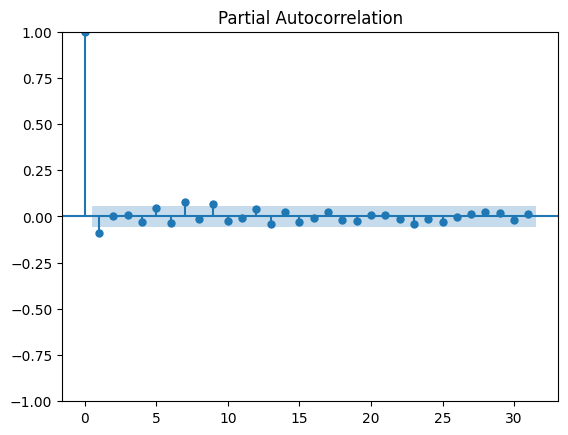

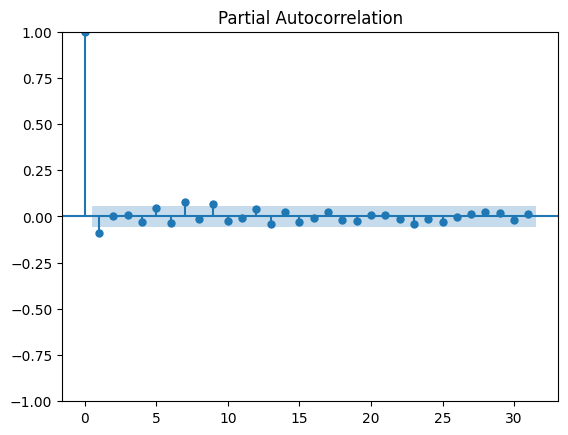

In [73]:
plot_pacf(ts_df["logdiff"].dropna())